# Animal Image Classification using CNN

This notebook demonstrates how to build a Convolutional Neural Network (CNN) to classify animal images. The dataset, containing 10 animal categories, is sourced from Kaggle (Animals10 dataset).

The dataset consist of about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.


### Objectives:
- Download data from Kaggle
- Preprocess and prepare image data
- Build and train a CNN model using TensorFlow/Keras
- Evaluate and visualize performance
- Analyze misclassified samples

This serves as a complete image classification pipeline using deep learning.


This is the extentension of model_1 Notebook, which has accuracy of 0.62


Main Objective : Improve Accuracy using Data Augmention, dropout and Batch Normalization

Importing all the necessary libararies


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers  # To access layers more cleanly
from tensorflow.keras import regularizers

In [2]:
#!pip install torch torchvision


Download data from Kaggel

In [2]:
import kagglehub    ## Import the kagglehub library to interact with Kaggle datasets

# Download the latest version of the 'animals10' dataset from Kaggle
# The dataset is identified by the user 'alessiocorrado99' and the dataset name 'animals10'
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)   ## Print the local file path where the downloaded dataset is stored

Path to dataset files: /kaggle/input/animals10


In [50]:
val_size = 0.2  # 20% validation split

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/animals10/raw-img",
    labels="inferred",
    label_mode="int",
    validation_split=val_size,
    subset="training",
    seed=123,  # fixed seed for reproducibility
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/animals10/raw-img",
    labels="inferred",
    label_mode="int",
    validation_split=val_size,
    subset="validation",
    seed=123,  # same seed as above!
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

print("Classes found:", train_ds.class_names)

# Optimize performance with caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [51]:
class_names = dataset.class_names

Ploting random 5 images from each class

Found 26179 files belonging to 10 classes.


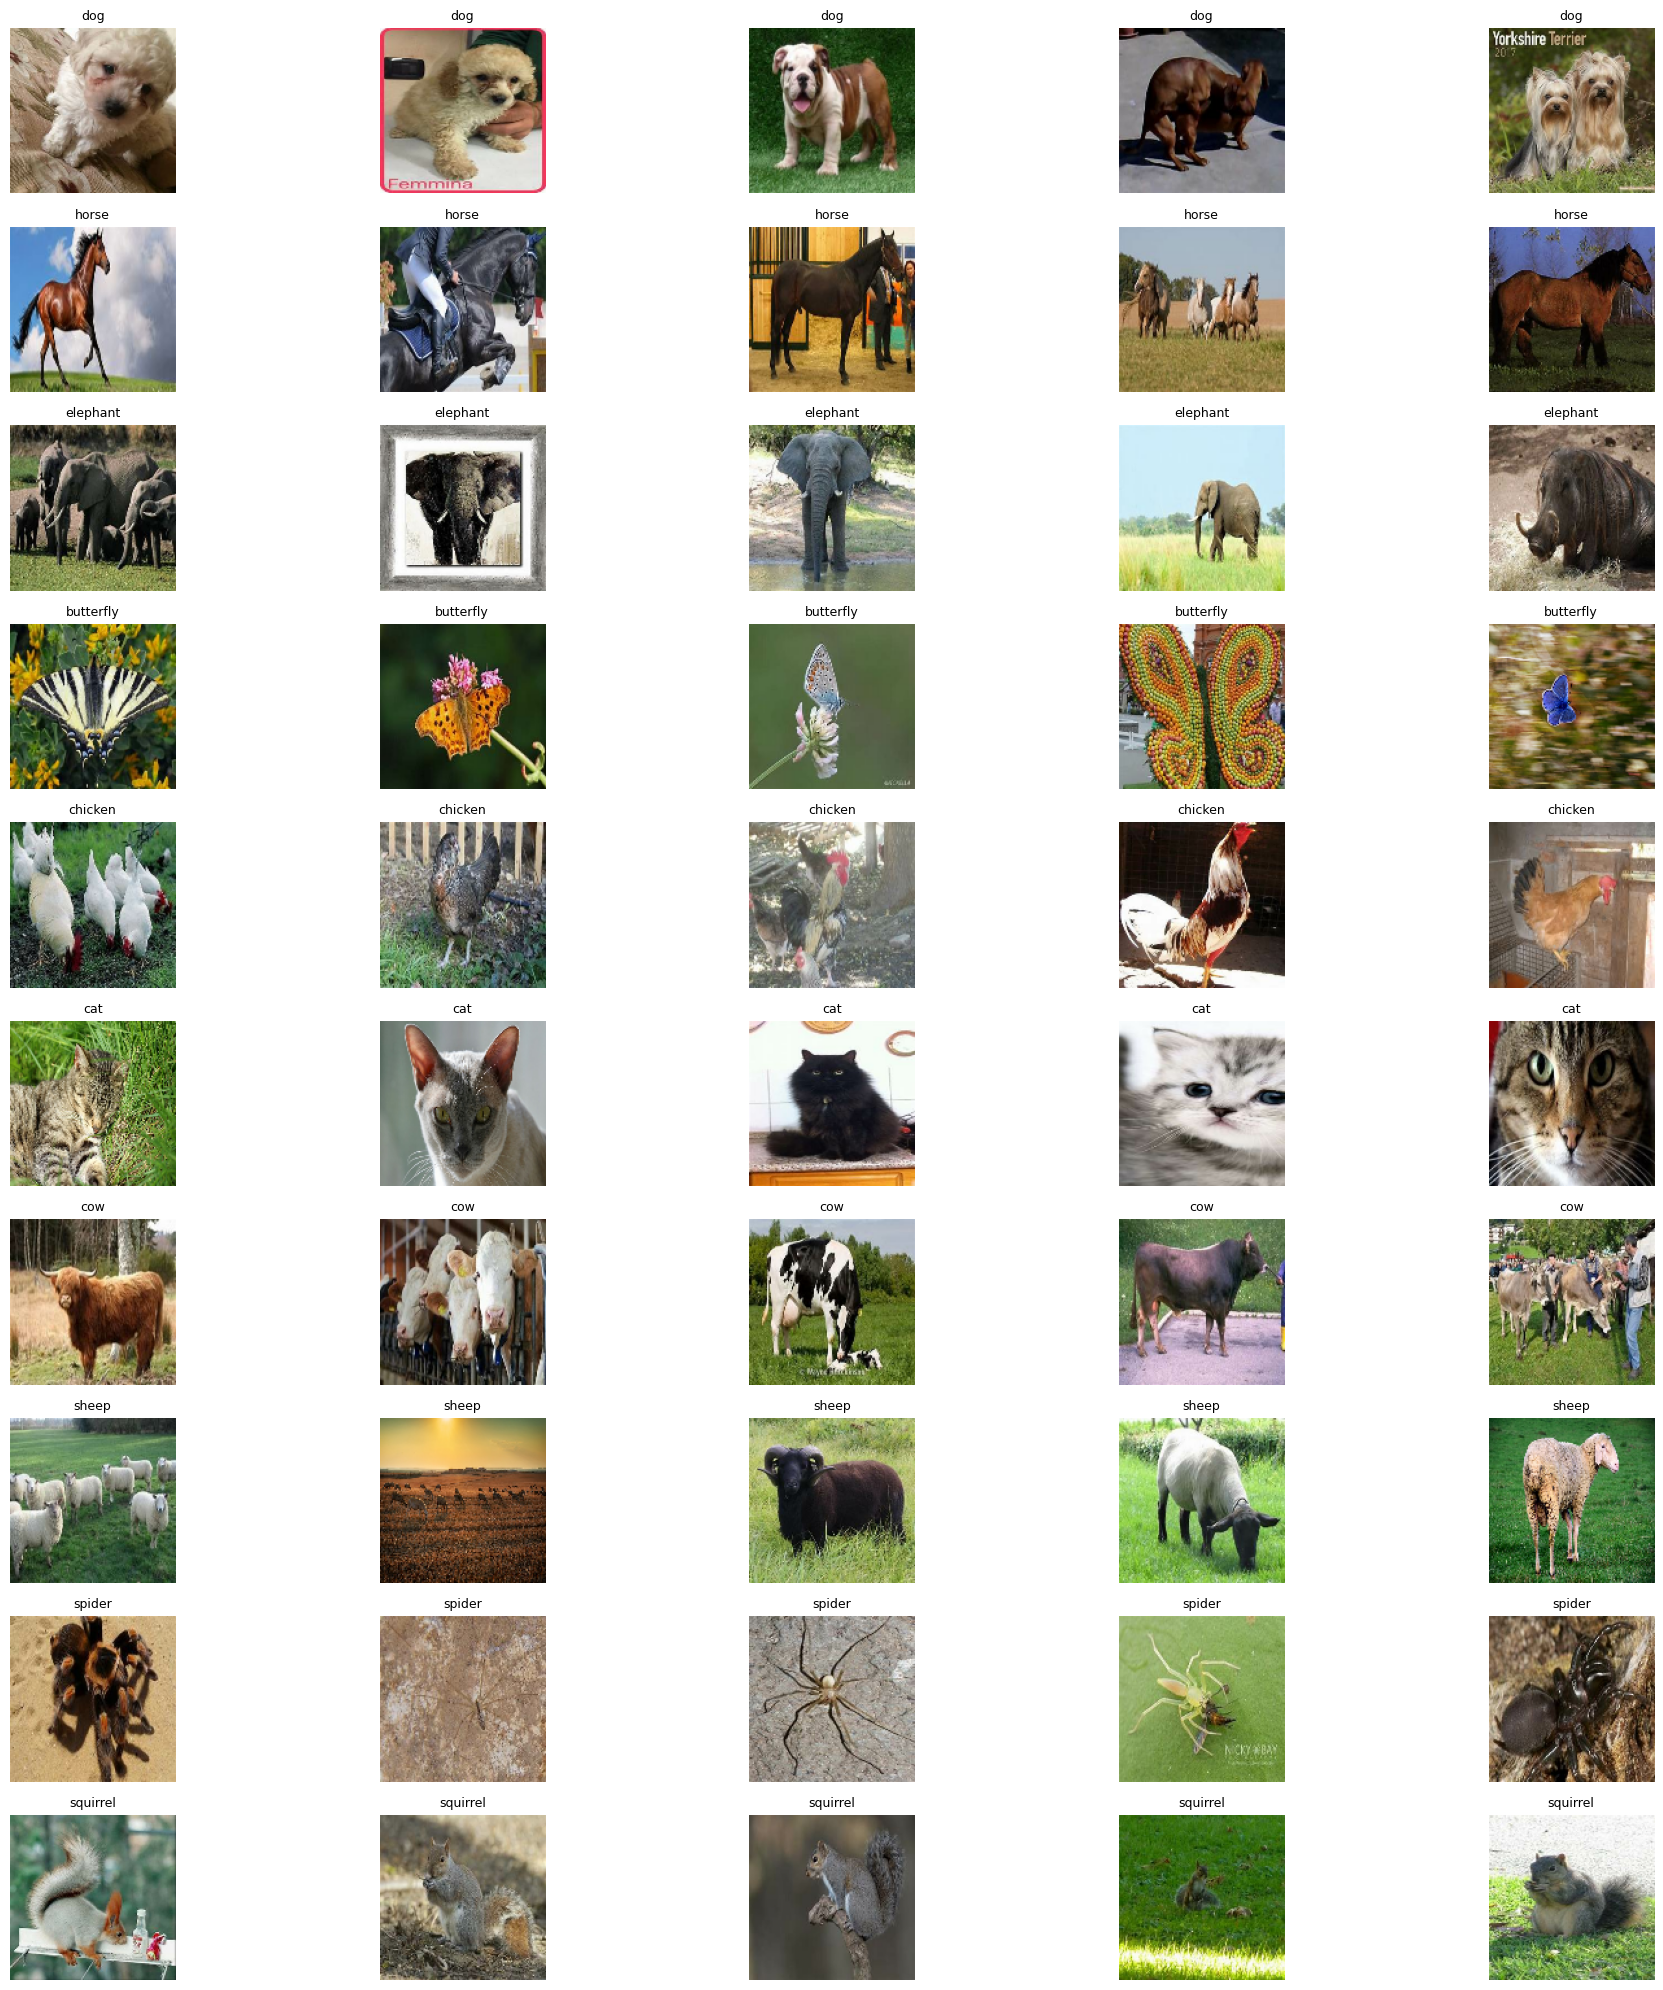

In [28]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

# Italian to English class name mapping
class_name_map = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

# Prepare data
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/animals10/raw-img",
    labels="inferred",
    label_mode="int",
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

# Extract class names and make a full list of (image, label) pairs
class_names = dataset.class_names
all_images = []
all_labels = []

for images, labels in dataset.unbatch():
    all_images.append(images.numpy().astype("uint8"))
    all_labels.append(labels.numpy())

# Convert to NumPy for easier handling
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Plot 5 random samples from each class
plt.figure(figsize=(20, 20))
for class_idx, class_name in enumerate(class_names):
    # Get indices for this class
    idxs = np.where(all_labels == class_idx)[0]
    # Randomly sample 5 images
    selected = np.random.choice(idxs, 5, replace=False)

    for i, img_idx in enumerate(selected):
        plt.subplot(10, 5, class_idx * 5 + i + 1)
        plt.imshow(all_images[img_idx])
        plt.axis("off")
        eng_name = class_name_map[class_name]
        plt.title(f"{eng_name}", fontsize=9)

plt.tight_layout()
plt.show()


Preprocessing of data and splitting

In [29]:
for images, labels in train_ds.take(1):
    print("Train images shape:", images.shape)
    print("Train labels shape:", labels.shape)

for images, labels in val_ds.take(1):
    print("Validation images shape:", images.shape)
    print("Validation labels shape:", labels.shape)

Train images shape: (32, 128, 128, 3)
Train labels shape: (32,)
Validation images shape: (32, 128, 128, 3)
Validation labels shape: (32,)


# Define augmentation layer

In [6]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
# ])

In [35]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),             # natural for many objects
#     layers.RandomRotation(0.05),                 # small rotation (±5%)
#     layers.RandomZoom(0.05),                     # slight zoom in/out
#     layers.RandomTranslation(0.05, 0.05),        # tiny shifts (5%)
# ])


Model Initialization

In [65]:
from tensorflow.keras import layers, models

#Data augmentation (mild)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),       # Flip images left-right
    layers.RandomRotation(0.05),           # Slightly rotate images
    layers.RandomZoom(0.05),               # Slight zoom in/out
    layers.RandomTranslation(0.05, 0.05)   # Slight shift in X and Y
])

model = models.Sequential([
    #data_augmentation,  # Apply augmentation to training images only

    layers.Rescaling(1./255, input_shape=(128, 128, 3)),  # Normalize pixel values [0, 1]

    layers.Conv2D(32, 3, padding='same'),  # First convolutional layer
    layers.BatchNormalization(),           # Normalize activations, helps with training speed and stability
    layers.Activation('relu'),             # ReLU activation function
    layers.MaxPooling2D(),                 # Downsample feature maps
    #layers.Dropout(0.2),                   # Prevent overfitting

    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),           # Normalize activations again
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    #layers.Dropout(0.2),

    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),           # Normalize for deeper layer
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    #layers.Dropout(0.2),

    layers.GlobalAveragePooling2D(),       # Replaces Flatten: takes average over all feature map positions
                                           # Reduces overfitting and model size by summarizing features

    layers.Dense(128, activation='relu'),  # Fully connected layer
    #layers.Dropout(0.5),                   # Dropout to reduce overfitting
    layers.Dense(10, activation='softmax') # Output layer: 10 classes
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Compilation

In [66]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Print model summary
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

Model Training

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [70]:
history = model.fit(train_ds,validation_data=val_ds,epochs=50,callbacks=[early_stop])


Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6042 - loss: 1.1593 - val_accuracy: 0.5608 - val_loss: 1.2678
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6145 - loss: 1.1427 - val_accuracy: 0.5230 - val_loss: 1.3818
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6197 - loss: 1.1186 - val_accuracy: 0.5452 - val_loss: 1.3319
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6260 - loss: 1.1116 - val_accuracy: 0.5654 - val_loss: 1.2677
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6210 - loss: 1.1150 - val_accuracy: 0.6120 - val_loss: 1.1484
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6366 - loss: 1.0789 - val_accuracy: 0.4420 - val_loss: 1.6928
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6327 - loss: 1.0703 - val_accuracy: 0.5522 - val_loss: 1.3492
Epoch 8/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6402 - loss: 1.0665 - 

With Data Augmention:  Train_Accuracy : 0.73   Test Accuracy: 0.6697

without Data Augmention + with dropout +Batch normalization: Train accuracy = 0.56, Test accuracy = 0.466

In [78]:
train_accuracy = history.history['accuracy']


# Print last epoch accuracy
print("Final Training Accuracy:", train_accuracy[-1])


Final Training Accuracy: 0.7367265224456787


In [76]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.4f}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6789 - loss: 0.9624
Validation accuracy: 0.6697


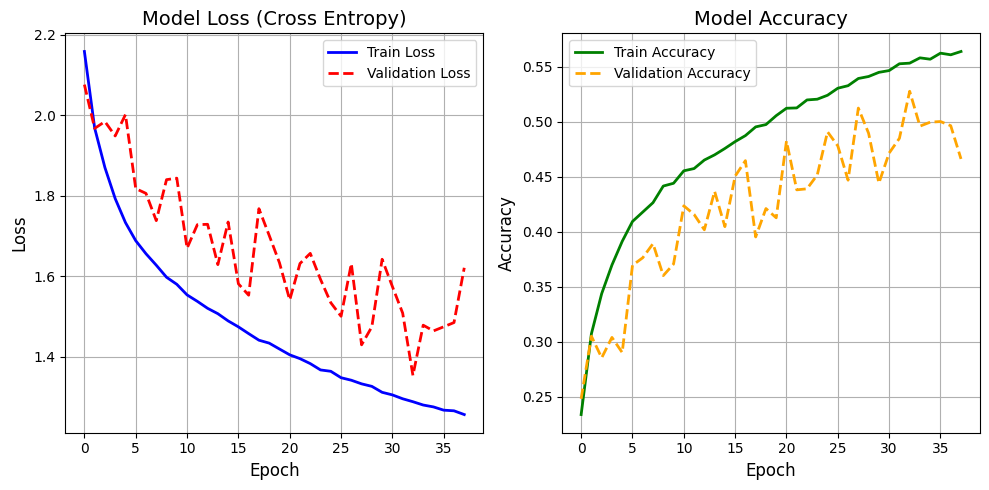

In [41]:
import matplotlib.pyplot as plt

# Set figure size and layout
plt.figure(figsize=(10, 5))

# --- Loss plot ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)
plt.title('Model Loss (Cross Entropy)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# --- Accuracy plot ---
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Final layout
plt.tight_layout()
plt.show()

Evaluation

In [79]:
class_names = [
    "Butterfly", "Cat", "Cow", "Dog", "Elephant",
    "Horse", "Lion", "Sheep", "Spider", "Squirrel"
]

Get Predictions on Validation Set

In [85]:
import numpy as np

# y_true = []
# y_pred = []

# for images, labels in val_ds:
#     preds = model.predict(images)
#     y_true.extend(labels.numpy())
#     y_pred.extend(np.argmax(preds, axis=1))


Plot the Confusion Matrix

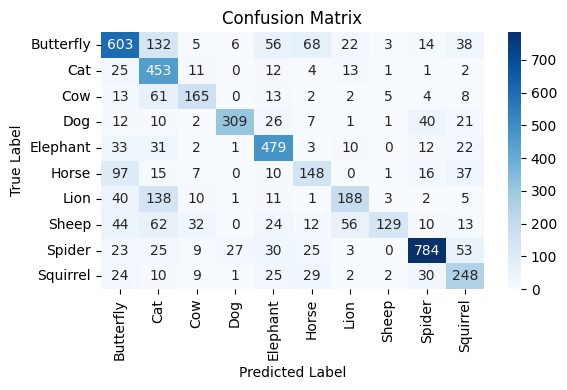

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



Classification Report

In [82]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

   Butterfly       0.66      0.64      0.65       947
         Cat       0.48      0.87      0.62       522
         Cow       0.65      0.60      0.63       273
         Dog       0.90      0.72      0.80       429
    Elephant       0.70      0.81      0.75       593
       Horse       0.49      0.45      0.47       331
        Lion       0.63      0.47      0.54       399
       Sheep       0.89      0.34      0.49       382
      Spider       0.86      0.80      0.83       979
    Squirrel       0.55      0.65      0.60       380

    accuracy                           0.67      5235
   macro avg       0.68      0.63      0.64      5235
weighted avg       0.70      0.67      0.67      5235



Per-Class Accuracy Bar Plot #Helps you identify which classes your model performs well or poorly on.

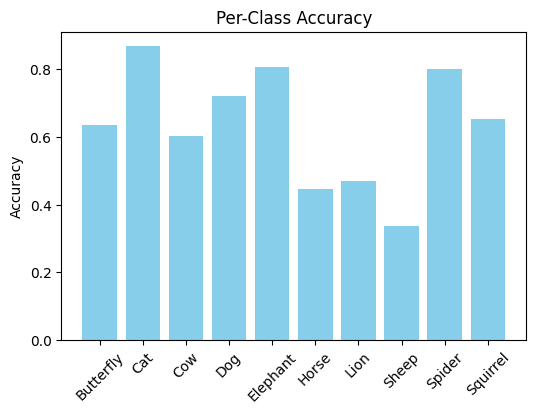

In [83]:
import numpy as np
from sklearn.metrics import accuracy_score

# Per-class accuracy
per_class_acc = []
y_true = np.array(y_true)
y_pred = np.array(y_pred)

for i in range(len(class_names)):
    mask = y_true == i
    acc = accuracy_score(y_true[mask], y_pred[mask])
    per_class_acc.append(acc)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(class_names, per_class_acc, color="skyblue")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.show()


 Incorrectly Classified Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

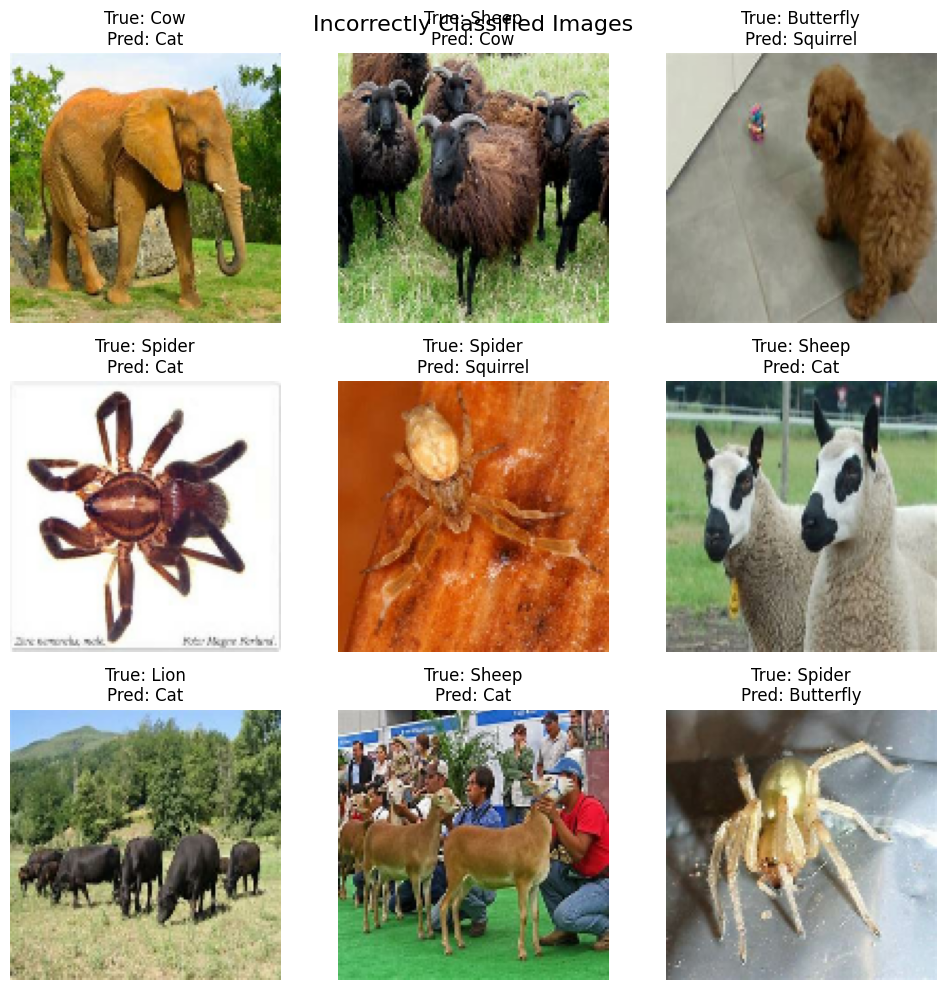

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Collect some misclassified examples
wrong = []
for images, labels in val_ds:
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    for img, true, pred in zip(images, labels.numpy(), pred_labels):
        if true != pred and len(wrong) < 9:
            wrong.append((img, true, pred))

# Plot
plt.figure(figsize=(10, 10))
for i, (img, true, pred) in enumerate(wrong):
    plt.subplot(3, 3, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Incorrectly Classified Images", fontsize=16)
plt.show()


Conclusion: Data Augmention is reducing the effect of overfitting but still not giving the best accuracy, we can work on changing the model defination, by adding more convolution layer , changing the learning rate ,
With Data Augmention: Train_Accuracy : 0.73 Test Accuracy: 0.6697